In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import numpy as np
import pandas as pd
import gzip
import shutil
from collections import defaultdict
from pathlib import Path
import joblib
from tqdm.autonotebook import tqdm, trange

In [3]:
data_path = Path('data/w4c22/')

#### Paragraph "Dataset" from subsection "Model-independent configurations"

In [4]:
min_rain = np.infty
max_rain = -np.infty

masks = defaultdict(lambda: defaultdict(dict))

for filename in tqdm(sorted(data_path.glob('**/*.rates.crop.h5'), key=lambda x: (x.stem.split('.')[0], x.parts[2], x.stem.split('.')[1]))):
    f = h5py.File(filename, 'r')
    x = f['rates.crop'][:]
    # x[x == -8888000.0] = np.nan
    x[x == -9999000.0] = np.nan
    nan_mask = np.isnan(x)
    mask = (x >= 0.2)
    mask[nan_mask] = np.nan
    mask = np.nanmean(mask, axis=(0, 1))
    rain_ratio_min, rain_ratio_mean, rain_ratio_max = mask.min(), mask.mean(), mask.max()
    region, split, *_ = filename.stem.split('.')
    year = filename.parts[2]
    masks[region][int(year)][split] = mask
    print(f"{region}-{split: <5} ({year}): from {rain_ratio_min:0.4f} to {rain_ratio_max:0.4f} with mean {rain_ratio_mean:0.4f}")
    if split == 'val' and year == '2020':
        print('\n')
    min_rain = min(rain_ratio_min, min_rain)
    max_rain = max(rain_ratio_max, max_rain)

joblib.dump(dict(masks), 'masks_nan_9.joblib')

  0%|          | 0/28 [00:00<?, ?it/s]

boxi_0015-train (2019): from 0.0553 to 0.1017 with mean 0.0732
boxi_0015-val   (2019): from 0.0417 to 0.0986 with mean 0.0596
boxi_0015-train (2020): from 0.0676 to 0.1204 with mean 0.0807
boxi_0015-val   (2020): from 0.0454 to 0.1676 with mean 0.0888


boxi_0034-train (2019): from 0.0341 to 0.1240 with mean 0.0602
boxi_0034-val   (2019): from 0.0398 to 0.1282 with mean 0.0688
boxi_0034-train (2020): from 0.0600 to 0.1486 with mean 0.0873
boxi_0034-val   (2020): from 0.0625 to 0.1477 with mean 0.0892


boxi_0076-train (2019): from 0.0229 to 0.1556 with mean 0.0544
boxi_0076-val   (2019): from 0.0222 to 0.1838 with mean 0.0611
boxi_0076-train (2020): from 0.0210 to 0.0838 with mean 0.0414
boxi_0076-val   (2020): from 0.0264 to 0.1213 with mean 0.0671


roxi_0004-train (2019): from 0.0447 to 0.1742 with mean 0.1050
roxi_0004-val   (2019): from 0.0546 to 0.2093 with mean 0.1354
roxi_0004-train (2020): from 0.0751 to 0.2264 with mean 0.1410
roxi_0004-val   (2020): from 0.0778 to 0.2356 wit

['masks_nan_9.joblib']

In [5]:
x = joblib.load('masks.joblib')
x['boxi_0015'][2019]['train'].shape

(252, 252)

In [6]:
diff = x['boxi_0015'][2019]['train'] - x['boxi_0015'][2019]['val']
diff

array([[ 0.02568446,  0.02568446,  0.02568446, ...,  0.01009281,
         0.01009281,  0.0049901 ],
       [ 0.02255187,  0.02255187,  0.02255187, ...,  0.01009281,
         0.01009281,  0.0049901 ],
       [ 0.02631494,  0.02255187,  0.02255187, ...,  0.00629108,
         0.00629108,  0.00308946],
       ...,
       [ 0.01679661,  0.01665855,  0.01665855, ..., -0.01087119,
        -0.01087119, -0.01087119],
       [ 0.01575196,  0.01665855,  0.01665855, ..., -0.01087119,
        -0.01445708, -0.01445708],
       [ 0.01575196,  0.01668755,  0.01668755, ..., -0.01445708,
        -0.01445708, -0.01445708]])

In [7]:
alpha = 1 / (1 + diff)
alpha

array([[0.97495871, 0.97495871, 0.97495871, ..., 0.99000804, 0.99000804,
        0.99503468],
       [0.9779455 , 0.9779455 , 0.9779455 , ..., 0.99000804, 0.99000804,
        0.99503468],
       [0.97435979, 0.9779455 , 0.9779455 , ..., 0.99374825, 0.99374825,
        0.99692006],
       ...,
       [0.98348086, 0.98361441, 0.98361441, ..., 1.01099068, 1.01099068,
        1.01099068],
       [0.98449232, 0.98361441, 0.98361441, ..., 1.01099068, 1.01466916,
        1.01466916],
       [0.98449232, 0.98358635, 0.98358635, ..., 1.01466916, 1.01466916,
        1.01466916]])

### Code to produce Figure 1

In [8]:
sub_file = h5py.File('submission/archive/heldout/majority_vote/unzipped/majority_vote/2019/roxi_0004.pred.h5', 'r')
sub = sub_file['submission'][:]
sub.mean(axis=(1, 2, 3)).argsort()

array([ 0, 24, 27, 30, 32, 35, 37, 38, 42, 45, 46, 49, 50, 51, 55, 56, 20,
       19, 29, 17,  6, 18, 10, 12, 13, 59, 15, 57, 22, 40,  8, 25, 11, 41,
        3, 52,  9, 54, 34,  5, 26, 21, 48, 16, 44, 53, 36, 23,  7, 39, 28,
       14, 58,  4,  1, 31,  2, 33, 43, 47])

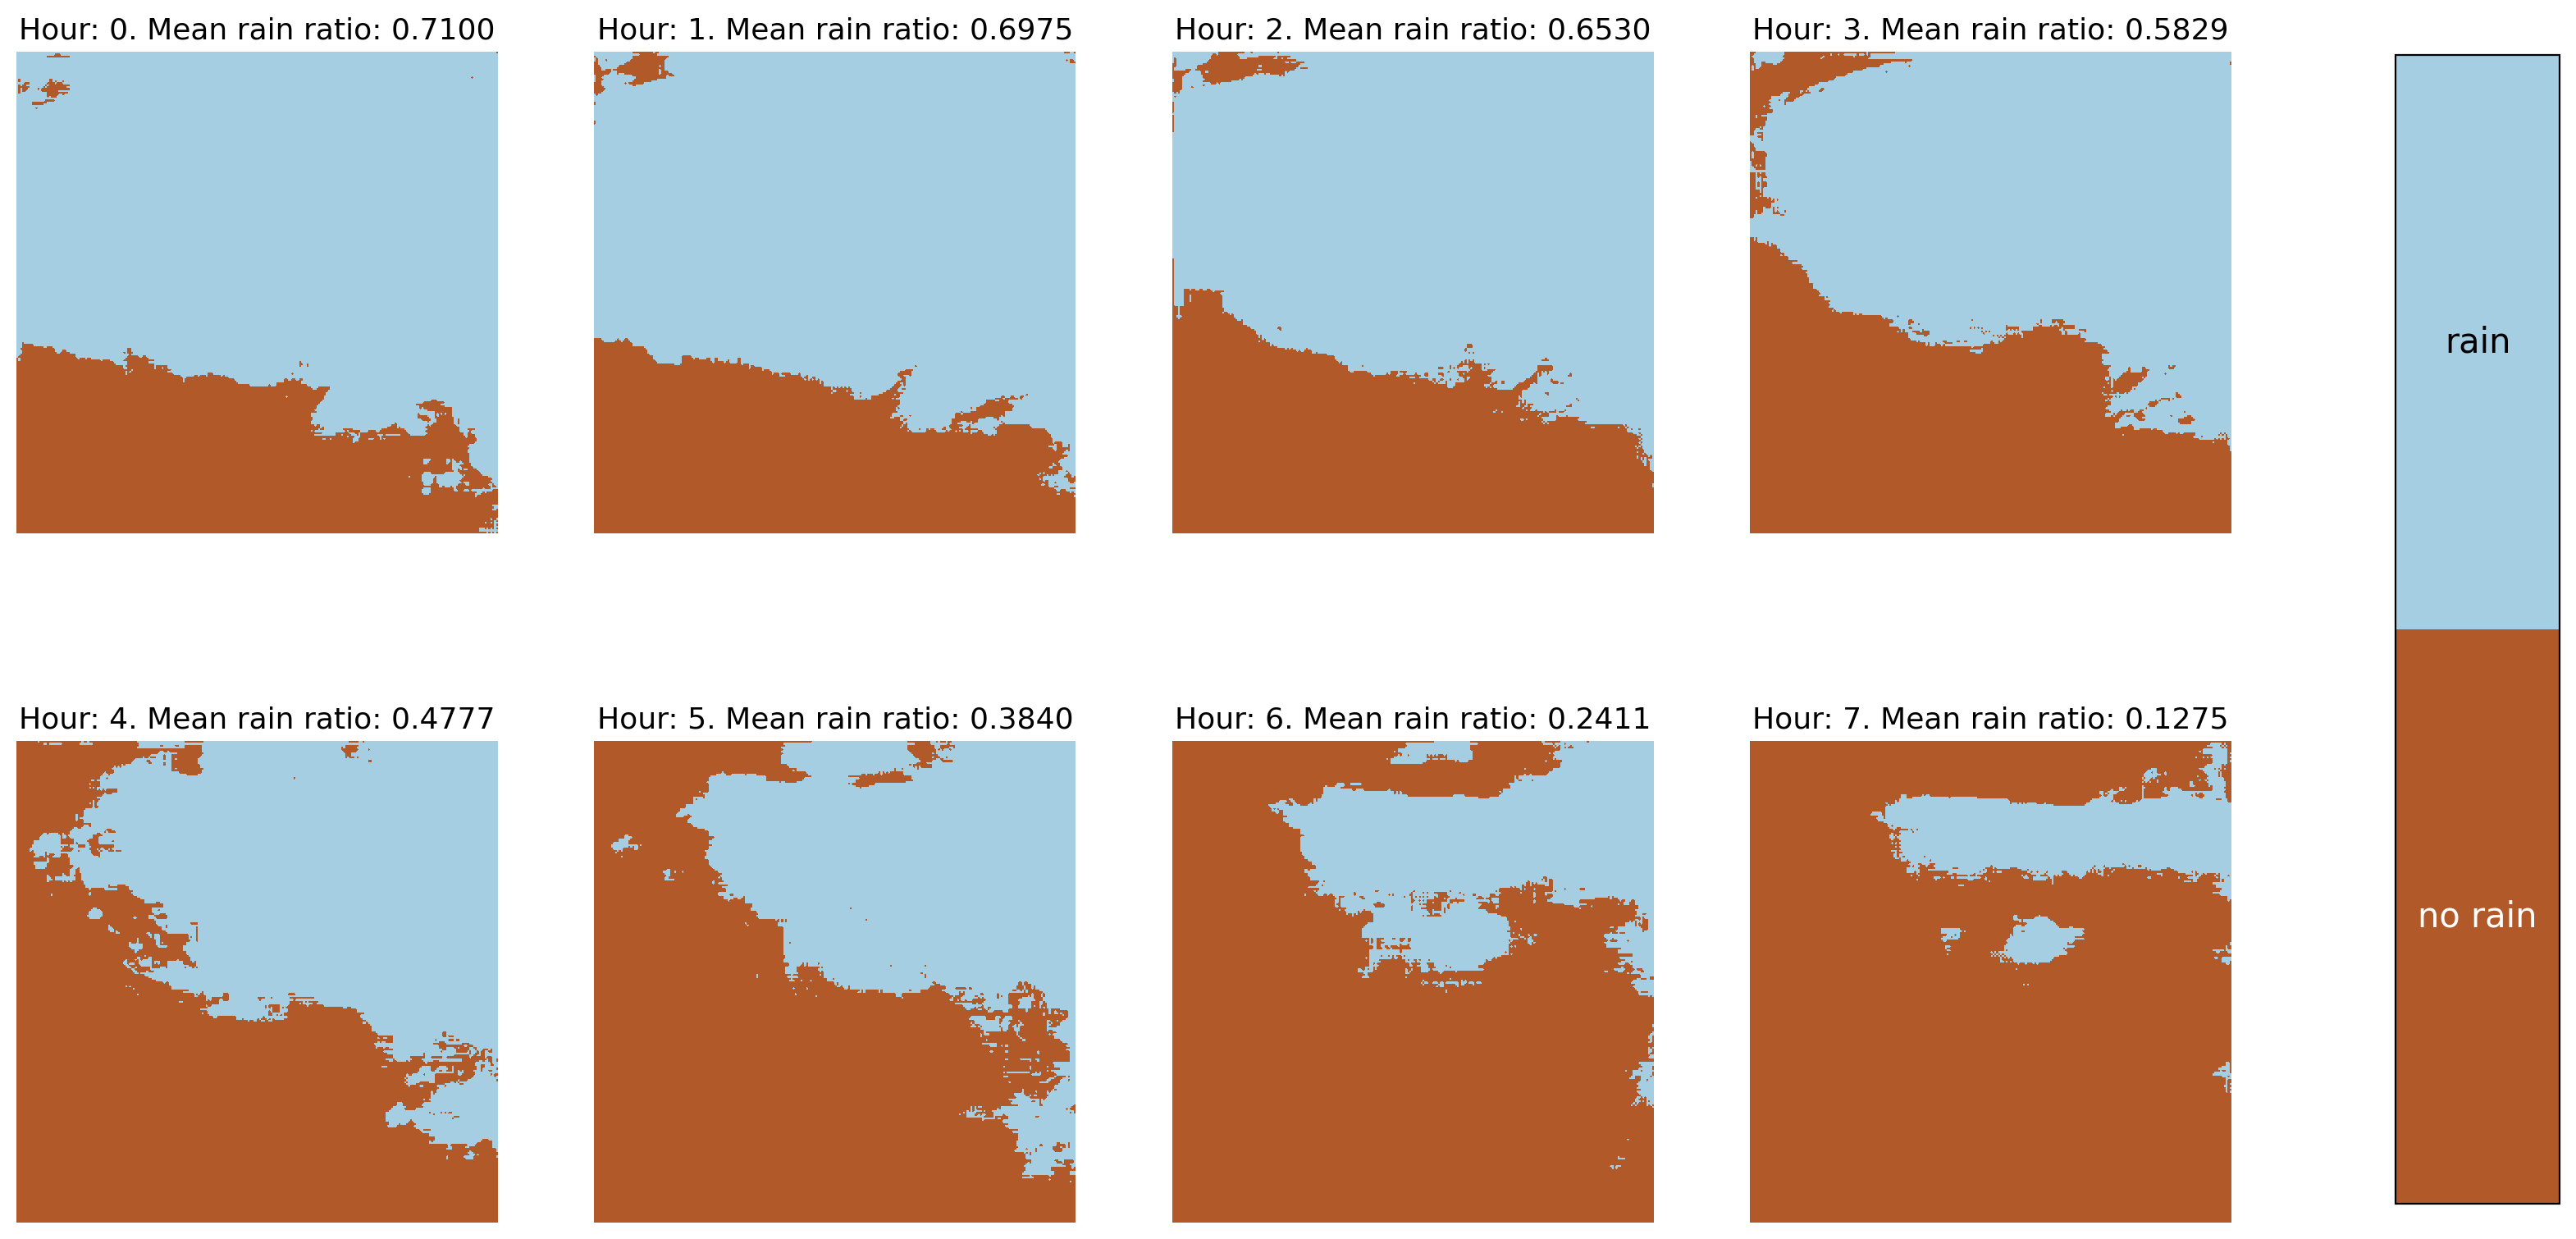

In [9]:
fig, axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=4)
selected_time = 23
# get discrete colormap
cmap = plt.get_cmap('Paired_r', 2)
for i, ax in enumerate(axes.flatten()):
    time = i * 4
    sub_at_time = sub[selected_time][time]
    im = ax.imshow(sub_at_time, cmap=cmap, vmin=0, vmax=1)
    ax.axis('off')
    ax.set_title(f"Hour: {time // 4}. Mean rain ratio: {sub_at_time.mean():.4f}", fontsize=13)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, ticks=[0, 1])
cbar_ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['no rain','rain']):
    cbar_ax.text(.5, (2 * j + 1) / 4.0, lab, ha='center', va='center', color='white' if j < 1 else 'black', fontsize=15)
plt.savefig(f"submission__roxi_0004_2020_at_{selected_time}.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Code to generate Table 1 and 2

In [10]:
def model_name_to_type(x):
    for model_type in ['baseline', 'swin', 'vivit']:
        if model_type in x.lower():
            return model_type
    return 'other'

def model_name_to_loss(x):
    if 'official' in x.lower():
        return 'bce'
    for loss in ['bce', 'dice_focal', 'IoU']:
        if loss.lower() in x.lower():
            return loss
    return 'other'

In [11]:
results_per_region = joblib.load('results_per_submission_heldout.joblib') # output from `parse_all_submissions.py`
df = pd.DataFrame.from_dict(results_per_region)
df['take best prediction per region'] = df.drop(columns='official baseline').max(axis=1)
df = df.T
df['Total mean'] = df.mean(axis=1)
df['2019 mean'] = df.filter(regex='2019').mean(axis=1)
df['2020 mean'] = df.filter(regex='2020').mean(axis=1)
df = df[['Total mean', '2019 mean', '2020 mean']]
df.index.name = 'Submission name'
df = df.reset_index()
df['Model type'] = df['Submission name'].apply(model_name_to_type)
df['Loss'] = df['Submission name'].apply(model_name_to_loss)
df = df[['Model type', 'Loss'] + list(df.columns[0:-2])]
df['Submission name'] = df.apply(lambda x: '_'.join(x['Submission name'].split('_')[2:]) if x['Model type'] in {'baseline', 'swin'} and 'official' not in x['Submission name'] else x['Submission name'], axis=1)
df
# df.to_excel('results_per_submission.xlsx', index=False)
# df.to_csv('results_per_submission.csv', index=False)

,Model type,Loss,Submission name,Total mean,2019 mean,2020 mean
0,baseline,bce,official baseline,0.255085,0.259016,0.251153
1,baseline,other,improved_epoch_15,0.269615,0.261093,0.278137
2,swin,bce,bce_epoch_3,0.281390,0.282880,0.279900
3,other,other,majority_vote,0.299784,0.296496,0.303072
4,other,other,take best prediction per region,0.302430,0.301438,0.303423
